In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
torch.__version__

'2.9.0+cpu'

In [ ]:
torchvision.__version__

'0.24.0+cpu'

Set Up Device Agnostics

In [ ]:
torch.cuda.is_available()

False

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Set The Seed

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

Setting the Hyperparameters

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

Define Image Transformations

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])

Getting a Dataset


In [ ]:
train_dataset = datasets.CIFAR10(root="data",
                                  train = True,
                                 download = True,
                                 transform = transform)

100%|██████████| 170M/170M [00:02<00:00, 72.8MB/s]


In [ ]:
test_dataset = datasets.CIFAR10(root = "data",
                                train = False,
                                download = True,
                                transform = transform)

In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
len(test_dataset)

10000

Converting our datasets into Dataloaders

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size =BATCH_SIZE,
                          shuffle = True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False)

In [ ]:
print(f"Dataloader : {train_loader, test_loader}")
print(f"Length of Trainloader : {len(train_loader)} batches of {BATCH_SIZE}..")
print(f"Length of Testloader : {len(test_loader)} batches of {BATCH_SIZE}..")

Dataloader : (<torch.utils.data.dataloader.DataLoader object at 0x785ade0716a0>, <torch.utils.data.dataloader.DataLoader object at 0x785b05baca70>)
Length of Trainloader : 391 batches of 128..
Length of Testloader : 79 batches of 128..


BUILDING VISION TRANSFORMER MODEL FROM SCRATCH

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__ (self,
                img_size,
                patch_size,
                in_channels,
                emd_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels=emd_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size // patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1,1,emd_dim))
    self.pos_embed = nn.Parameter(torch.randn(1,1+num_patches,emd_dim))

  def forward(self,x: torch.Tensor):
   B = x.size(0)
   x = self.proj(x)
   x = x.flatten(2).transpose(1,2)
   cls_token = self.cls_token.expand(B,-1,-1)
   x = torch.cat((cls_token,x),dim=1)
   x = x + self.pos_embed
   return x

In [ ]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features,
                         out_features=hidden_features)
    self.dropout = nn.Dropout(p=drop_rate)
    self.fc2 = nn.Linear(in_features=hidden_features,
                         out_features=in_features)

  def forward(self,x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,embed_dim,num_heads,mlp_dim,drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim,num_heads,dropout=drop_rate,batch_first=True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim,mlp_dim,drop_rate)

  def forward(self,x):
    x = x + self.attn(self.norm1(x), self.norm1(x),self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,num_classes,embed_dim,num_heads,depth,mlp_dim,drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size,
                                      patch_size,
                                      in_channels,
                                      embed_dim)
    self.encoder = nn.Sequential(*[TransformerEncoderLayer(embed_dim,num_heads,mlp_dim,drop_rate)
    for _ in range(depth)])
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim,num_classes)

  def forward(self,x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:,0]
    return self.head(cls_token)

Instantiate Model

In [ ]:
from IPython.core.display import Image
model = VisionTransformer(
    IMAGE_SIZE,
    PATCH_SIZE,
    CHANNELS,
    NUM_CLASSES,
    EMBED_DIM,
    NUM_HEADS,
    DEPTH,
    MLP_DIM,
    DROP_RATE
).to(device)

In [ ]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

Defiinig a Loss Function and an Optimizer


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params = model.parameters(), lr=LEARNING_RATE)

In [ ]:
criterion

CrossEntropyLoss()

In [ ]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
)

Definig a Training Loop function


In [ ]:
def train(model, loader, optimizer, criterion):
  model.train()
  total_loss, correct = 0,0
  for x,y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out,y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * x.size(0)
    correct += (out.argmax(1) == y).sum().item()

  return total_loss / len(loader.dataset), correct / len(loader.dataset)


In [ ]:
def evaluate(model, loader):
  model.eval()
  correct = 0
  with torch.inference_mode():
    for x,y in loader:
      x, y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(dim=1) == y).sum().item()

  return correct / len(loader.dataset)

Training

In [ ]:
from tqdm.auto import tqdm

In [ ]:
train_accuracies = []
test_accuracies = []
for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch : {epoch+1}/{EPOCHS}..",
        f"Train Loss : {train_loss:.4f} | Train Acc : {train_acc*100:.2f}% | Test Acc : {test_acc*100:.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1/10.. Train Loss : 1.7287 | Train Acc : 37.27% | Test Acc : 47.98%
Epoch : 2/10.. Train Loss : 1.3877 | Train Acc : 50.21% | Test Acc : 53.16%
Epoch : 3/10.. Train Loss : 1.2357 | Train Acc : 55.73% | Test Acc : 57.33%
Epoch : 4/10.. Train Loss : 1.1320 | Train Acc : 59.32% | Test Acc : 58.19%
Epoch : 5/10.. Train Loss : 1.0468 | Train Acc : 62.74% | Test Acc : 60.17%
Epoch : 6/10.. Train Loss : 0.9667 | Train Acc : 65.55% | Test Acc : 61.00%
Epoch : 7/10.. Train Loss : 0.8897 | Train Acc : 68.07% | Test Acc : 61.40%
Epoch : 8/10.. Train Loss : 0.8268 | Train Acc : 70.44% | Test Acc : 62.62%
Epoch : 9/10.. Train Loss : 0.7549 | Train Acc : 72.98% | Test Acc : 63.25%
Epoch : 10/10.. Train Loss : 0.6886 | Train Acc : 75.42% | Test Acc : 63.25%


In [ ]:
train_accuracies


[0.3727,
 0.50212,
 0.55732,
 0.59322,
 0.6274,
 0.65552,
 0.68072,
 0.7044,
 0.72984,
 0.75416]

In [ ]:
test_accuracies

[0.4798, 0.5316, 0.5733, 0.5819, 0.6017, 0.61, 0.614, 0.6262, 0.6325, 0.6325]

Plot Accuracy

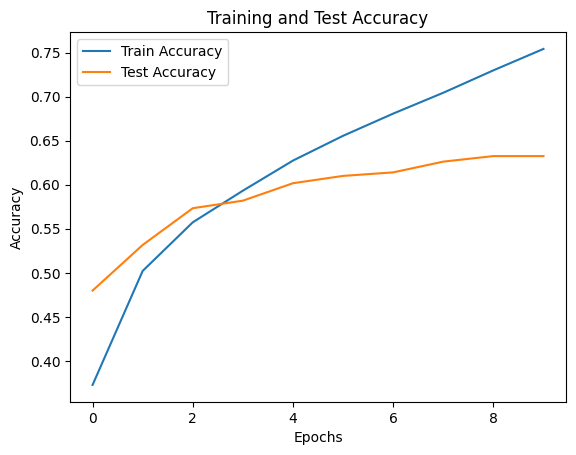

In [ ]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [ ]:
import random

In [ ]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
  model.eval()
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0, len(dataset)-1)
      img, true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _ , predicted = torch.max(output.data, 1)
      img = img / 2 + 0.5 # Unnormalize the image
      npimg = img.cpu().numpy()
      axes[i,j].imshow(np.transpose(npimg, (1,2,0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = 'g'
      else:
        color = 'r'

      axes[i,j].set_title(f"Truth: {classes[true_label]}\nPredicted: {classes[predicted.item()]}", fontsize = 10, c=color)
      axes[i,j].axis('off')
  plt.tight_layout()
  plt.show()

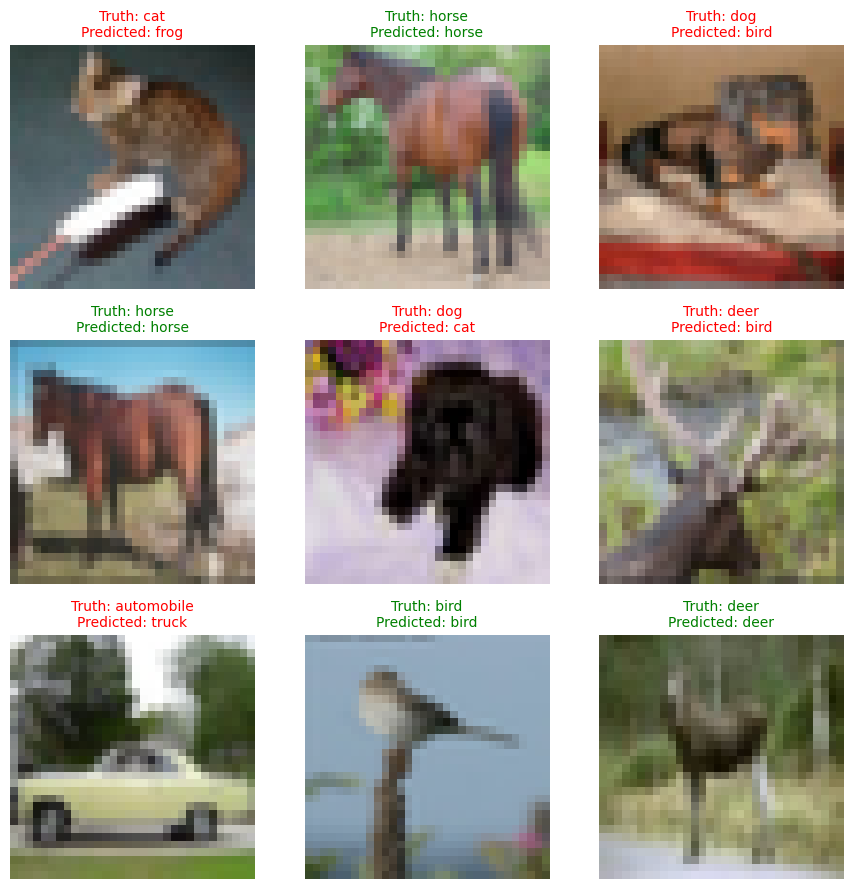

In [ ]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!git config --global user.name "pranavk-10 "
!git config --global user.email "mr.pranavkamble10@gmail.com"


In [ ]:
!git clone https://github.com/pranavk-10/vision-transformer-rtl.git


Cloning into 'vision-transformer-rtl'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), done.


In [ ]:
!cp /content/Vision_Transformer.ipynb /content/vision-transformer-rtl/software/


cp: cannot stat '/content/Vision_Transformer.ipynb': No such file or directory


In [ ]:
!ls /content


data  drive  sample_data  vision-transformer-rtl
